Import files from google drive, used for running in google colab


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link_dev = 'https://drive.google.com/open?id=1Zrs7nU_A7Gsr2RRl0TKDUSxKw4URCb68' 
link_ev = 'https://drive.google.com/open?id=1lbwaYhPdkuTIZOMYmq2YpGXcr9aS5DbN' 
link_ss = 'https://drive.google.com/open?id=1F9AemFOhf30iBkePtZll2lrpAqVX7S6b'
fluff, id_dev = link_dev.split('=')
fluff, id_ev = link_ev.split('=')
fluff, id_ss = link_ss.split('=')
downloaded = drive.CreateFile({'id':id_dev}) 
downloaded.GetContentFile('development.csv')  
downloaded = drive.CreateFile({'id':id_ev}) 
downloaded.GetContentFile('evaluation.csv')  
downloaded = drive.CreateFile({'id':id_ss}) 
downloaded.GetContentFile('stopwords.txt')  

Class Review

In [0]:
class Review:
    def __init__(self, text, text_clean, label):
        self.text = text
        self.text_clean = text_clean
        self.label = label
        
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]

    def get_text_clean(self):
        return [x.text_clean for x in self.reviews]
    
    def get_label(self):
        return [x.label for x in self.reviews]


Libraries

In [0]:
import io 
import re
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn import svm
from  nltk.stem.snowball import ItalianStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit
%matplotlib inline

Reading files

In [0]:
data_dev = pd.read_csv('development.csv', encoding='utf8')# Dataset is now stored in a Pandas Dataframe
data_ev = pd.read_csv('evaluation.csv', encoding='utf8')# Dataset is now stored in a Pandas Dataframe

In [7]:
data_dev.head()

,text,class
0,Non è l'hotel più lussuoso in cui abbia mai so...,pos
1,Siamo stati qui per 1 notte prima della nostra...,pos
2,Hotel è ben posizionato per visitare Torino. A...,pos
3,All'arrivo la cordialità e disponibilità dello...,pos
4,Abbiamo soggiornato per due notti alla fine de...,pos


In [8]:
data_ev.head()

,text
0,Mi sono fermato una sola notte essendo di pass...
1,Ho prenotato questo hotel per essere vicino al...
2,Si tratta di un hotel di lusso costruito nel X...
3,Arrivo alle 23:30 faccio check in e chiedo la ...
4,Sono pochi gli Hotel che riescono a coniugare ...


In [37]:
stop_words_data = pd.read_csv('stopwords.txt', sep=" ", header=None)
stop_words = list(stop_words_data[0])
print(stop_words)

['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'accidenti', 'ad', 'adesso', 'affinche', 'agl', 'agli', 'ahime', 'ahimã¨', 'ahimè', 'ai', 'al', 'alcuna', 'alcuni', 'alcuno', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altrimenti', 'altro', 'altrove', 'altrui', 'anche', 'ancora', 'anni', 'anno', 'ansa', 'anticipo', 'assai', 'attesa', 'attraverso', 'avanti', 'avemmo', 'avendo', 'avente', 'aver', 'avere', 'averlo', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', 'avevamo', 'avevano', 'avevate', 'avevi', 'avevo', 'avrai', 'avranno', 'avrebbe', 'avrebbero', 'avrei', 'avremmo', 'avremo', 'avreste', 'avresti', 'avrete', 'avrà', 'avrò', 'avuta', 'avute', 'avuti', 'avuto', 'basta', 'c', 'casa', 'caso', 'cento', 'che', 'chi', 'chicchessia', 'chiunque', 'ci', 'ciascuna', 'ciascuno', 'cima', 'cinque', 'cio', 'cioe', 'cioã¨', 'cioè', 'circa', 'ciã²', 'ciò', 'co', 'codesta', 'codesti', 'codesto', 'cogli', 'coi', 'col', 'colei', 'coll', 'coloro', 'col

In [0]:
stemmer = ItalianStemmer()
def clean_text(text):
  output_str = re.sub('[^A-Za-zàèéìòù]+', ' ', text)
  output_str_lower =re.sub('[A-Z]+', lambda m: m.group(0).lower(), output_str)
  output_noss = ' '.join(w for w in output_str_lower.split() if w not in stop_words) 
  output_stemming = [stemmer.stem(i) for i in output_noss.split()]
  output_stemming = ' '.join(output_stemming)
  return output_stemming

In [11]:
#test
print(clean_text("Ciao, sono silvia e ho 22 anni.Ciao, lui è il gatto più 'bello'"))

cia silv cia gatt bell


In [17]:
data_dev['text_clean'] = data_dev['text'].apply(lambda x: clean_text(x)) 
print("Dev done")
data_ev['text_clean'] = data_ev['text'].apply(lambda x: clean_text(x)) 

Dev done


Word cloud function

In [0]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12), dpi=90)
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

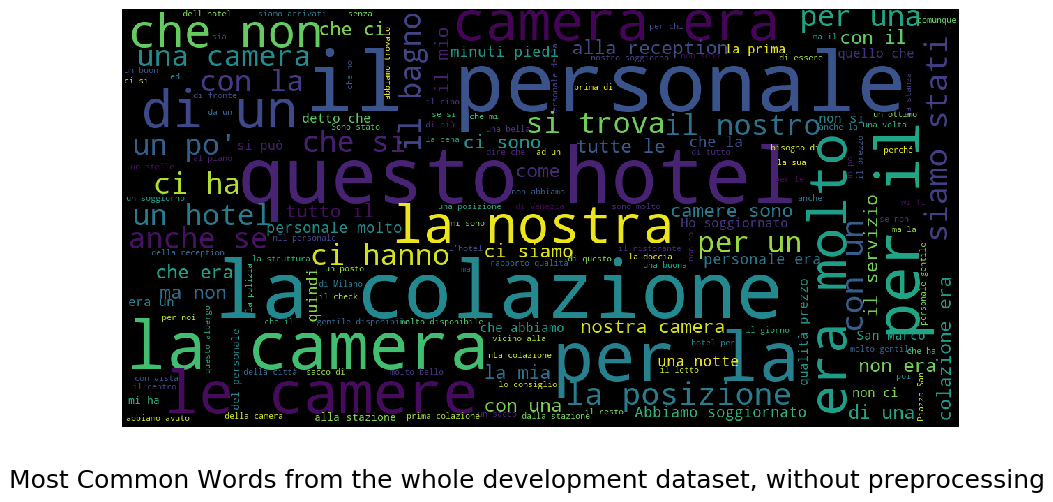

In [0]:
show_wordcloud(list(data_dev['text']), 'Most Common Words from the whole development dataset, without preprocessing')

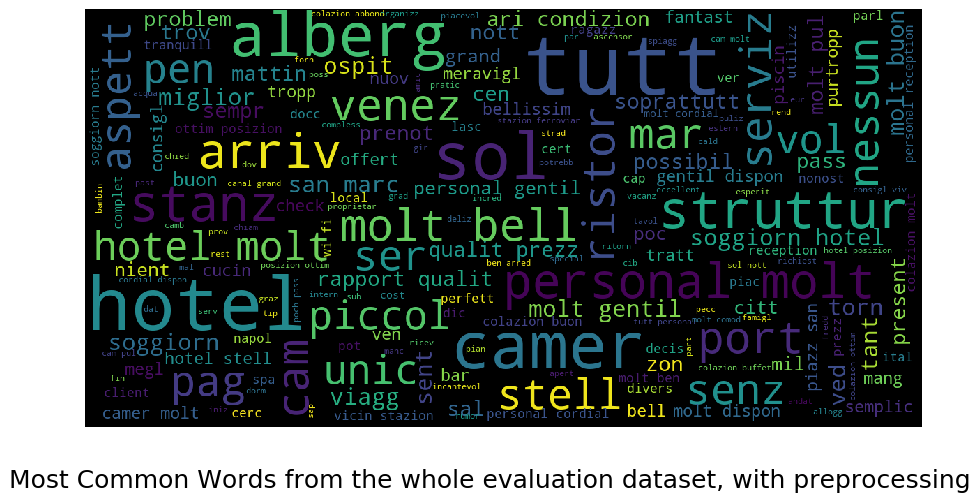

In [0]:
show_wordcloud(list(data_dev['text_clean']), 'Most Common Words from the whole evaluation dataset, with preprocessing')

In [18]:
reviews = []
for i,row in data_dev.iterrows():
    reviews.append(Review(data_dev.loc[i, 'text'], data_dev.loc[i, 'text_clean'],  data_dev.loc[i, 'class']))

print(reviews[5].text)
print(reviews[5].text_clean)
print(reviews[5].label)

Ho soggiornato nell'hotel Acca Palace per una sola notte con il mio fidanzato per andare ad un concerto. La posizione di certo non è delle migliori, ma a me interessava perché vicina al luogo del concerto. Abbiamo trovato una bella struttura, con una camera ampia, ben arredata e pulita, con un bel balconcino! La colazione poi è il top: vasta scelta, sia dolce che salato, ed ottima qualità! Consigliato a chi non ha necessità di stare in pieno centro (anche se è a due passi dalla fermata della metropolitana, che è una grandissima comodità!).
soggiorn hotel acca palac sol nott fidanz concert posizion cert miglior interess vicin concert bell struttur camer ampi ben arred pul bel balconcin colazion top vast scelt dolc sal ottim qualit consigl necess star in centr pass ferm metropolitan grandissim comod
pos


Reviews: 28754
Positive reviews: 19532
Negative reviews: 9222


Text(0, 0.5, 'Number of reviews ')

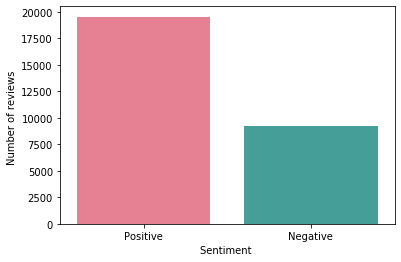

In [19]:
pos_reviews = [x.text for x in reviews if x.label == 'pos']
neg_reviews = [x.text for x in reviews if x.label == 'neg']
pos_reviews_clean = [x.text_clean for x in reviews if x.label == 'pos']
neg_reviews_clean = [x.text_clean for x in reviews if x.label == 'neg']
n_reviews = len(reviews)
n_pos_reviews = len(pos_reviews)
n_neg_reviews = len(neg_reviews)
print("Reviews:", n_reviews)
print("Positive reviews: " + str(n_pos_reviews))
print("Negative reviews: " + str(n_neg_reviews))

sns.barplot(['Positive', 'Negative'], [n_pos_reviews,n_neg_reviews], palette = "husl")
plt.xlabel('Sentiment ')
plt.ylabel('Number of reviews ')

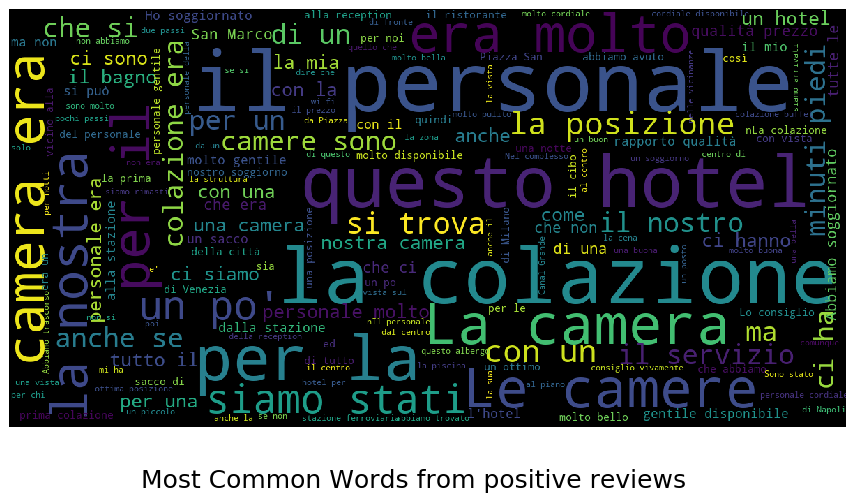

In [0]:
show_wordcloud(pos_reviews, 'Most Common Words from positive reviews')

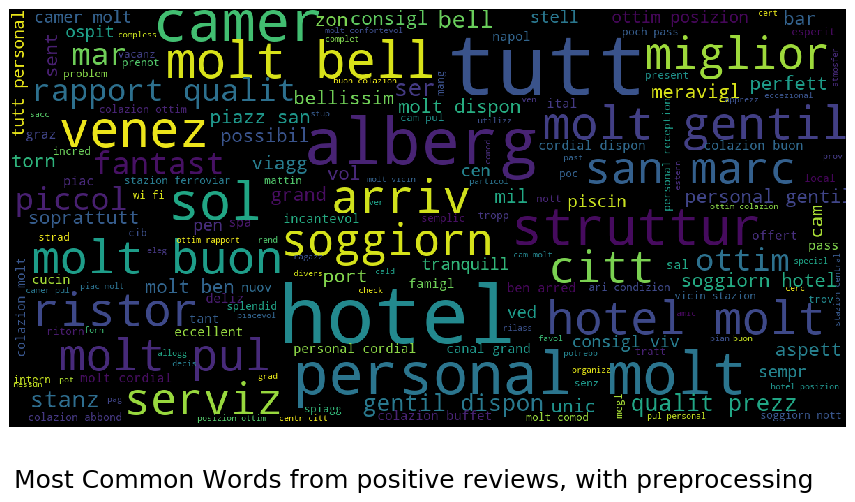

In [0]:
show_wordcloud(pos_reviews_clean, 'Most Common Words from positive reviews, with preprocessing')

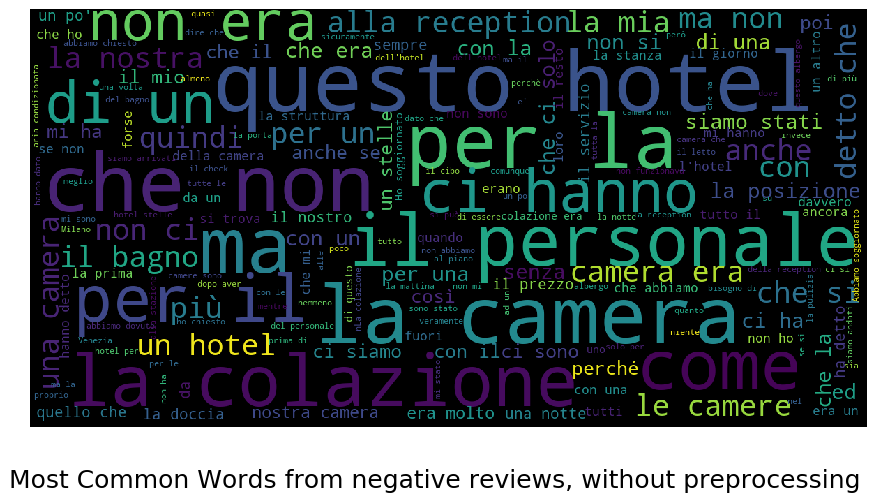

In [0]:
show_wordcloud(neg_reviews, 'Most Common Words from negative reviews')

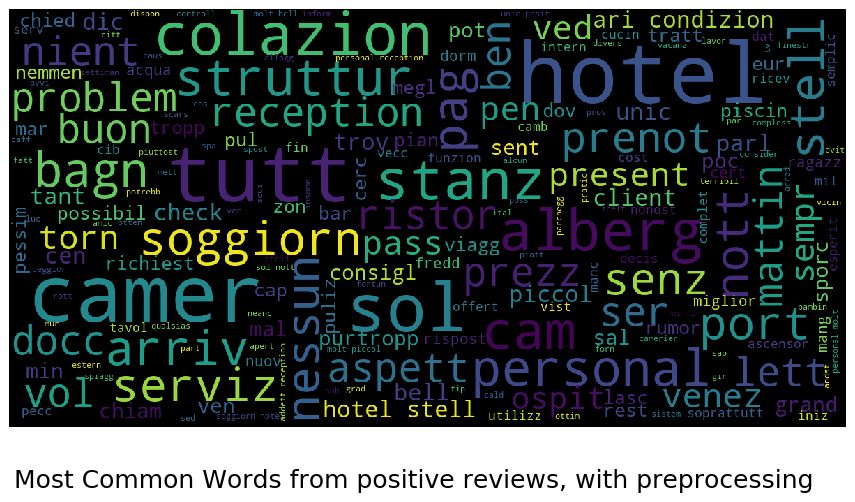

In [0]:
show_wordcloud(neg_reviews_clean, 'Most Common Words from positive reviews, with preprocessing')

CountVectorizer test

In [24]:
cv = CountVectorizer()
corpus = [ 'Questo hotel è bellissimo', 'Albergo bellissimo',  'Camere pulite']
test = cv.fit_transform(corpus) 
print(cv.get_feature_names())
print(test.toarray())

['albergo', 'bellissimo', 'camere', 'hotel', 'pulite', 'questo']
[[0 1 0 1 0 1]
 [1 1 0 0 0 0]
 [0 0 1 0 1 0]]


Tuning

In [26]:
params = {
  "min_df": [1, 2, 3, 4], 
  "max_df": [0.3, 0.35, 0.4, 0.45, 0.5, 0.55],
  "ngram_range": [(1,1), (1,2), (1,3)]
}

for config in ParameterGrid(params):
  print(config)

{'max_df': 0.3, 'min_df': 1, 'ngram_range': (1, 1)}
{'max_df': 0.3, 'min_df': 1, 'ngram_range': (1, 2)}
{'max_df': 0.3, 'min_df': 1, 'ngram_range': (1, 3)}
{'max_df': 0.3, 'min_df': 2, 'ngram_range': (1, 1)}
{'max_df': 0.3, 'min_df': 2, 'ngram_range': (1, 2)}
{'max_df': 0.3, 'min_df': 2, 'ngram_range': (1, 3)}
{'max_df': 0.3, 'min_df': 3, 'ngram_range': (1, 1)}
{'max_df': 0.3, 'min_df': 3, 'ngram_range': (1, 2)}
{'max_df': 0.3, 'min_df': 3, 'ngram_range': (1, 3)}
{'max_df': 0.3, 'min_df': 4, 'ngram_range': (1, 1)}
{'max_df': 0.3, 'min_df': 4, 'ngram_range': (1, 2)}
{'max_df': 0.3, 'min_df': 4, 'ngram_range': (1, 3)}
{'max_df': 0.35, 'min_df': 1, 'ngram_range': (1, 1)}
{'max_df': 0.35, 'min_df': 1, 'ngram_range': (1, 2)}
{'max_df': 0.35, 'min_df': 1, 'ngram_range': (1, 3)}
{'max_df': 0.35, 'min_df': 2, 'ngram_range': (1, 1)}
{'max_df': 0.35, 'min_df': 2, 'ngram_range': (1, 2)}
{'max_df': 0.35, 'min_df': 2, 'ngram_range': (1, 3)}
{'max_df': 0.35, 'min_df': 3, 'ngram_range': (1, 1)}
{'max

In [28]:
max_acc = 0
best_config = 0
j = 0
for config in ParameterGrid(params):
    pipe = Pipeline([('count', CountVectorizer(**config,  token_pattern=r'\b[^\d\W]+\b' )), ('tfid', TfidfTransformer())])
    vectors = pipe.fit_transform(data_dev.text) 
    X = vectors
    y = data_dev['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = svm.LinearSVC(C=1.3, tol=1e-9, dual=False, intercept_scaling=0.001, loss="squared_hinge", max_iter=10000, random_state=1, class_weight='balanced') 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    print("Model configuration n.", j)
    print("Parameter", config)
    print("F1 score: ", score)
    if score > max_acc:
      max_acc = score
      best_config = config
    j += 1

Model configuration n. 0
Parameter {'max_df': 0.3, 'min_df': 1, 'ngram_range': (1, 1)}
F1 score:  0.9597021605221885
Model configuration n. 1
Parameter {'max_df': 0.3, 'min_df': 1, 'ngram_range': (1, 2)}
F1 score:  0.9670570256077746
Model configuration n. 2
Parameter {'max_df': 0.3, 'min_df': 1, 'ngram_range': (1, 3)}
F1 score:  0.9649506052173973
Model configuration n. 3
Parameter {'max_df': 0.3, 'min_df': 2, 'ngram_range': (1, 1)}
F1 score:  0.9591783737408813
Model configuration n. 4
Parameter {'max_df': 0.3, 'min_df': 2, 'ngram_range': (1, 2)}
F1 score:  0.9677767120405774
Model configuration n. 5
Parameter {'max_df': 0.3, 'min_df': 2, 'ngram_range': (1, 3)}
F1 score:  0.9684646672057197
Model configuration n. 6
Parameter {'max_df': 0.3, 'min_df': 3, 'ngram_range': (1, 1)}
F1 score:  0.958301552952805
Model configuration n. 7
Parameter {'max_df': 0.3, 'min_df': 3, 'ngram_range': (1, 2)}
F1 score:  0.9676002846967364
Model configuration n. 8
Parameter {'max_df': 0.3, 'min_df': 3, '

In [29]:
print(max_acc)
print(best_config)

0.9688217916500722
{'max_df': 0.4, 'min_df': 3, 'ngram_range': (1, 3)}


In [0]:
#972 maxdf .5 mindf 3 ngram 1,3 binary true subl true
#selectkbest 130000
#C = 1
#0.9681
#3959
pipe = Pipeline([('count', CountVectorizer(max_df= 0.4, min_df=3,  ngram_range= (1, 3), token_pattern=r'\b[^\d\W]+\b')), ('tfid', TfidfTransformer())])
vectors = pipe.fit_transform(data_dev.text)

In [35]:
#vectorizer = TfidfVectorizer(max_df= 0.5, min_df= 3, ngram_range= (1, 3))
#vectors = vectorizer.fit_transform(data_dev.text)
X = vectors
y = data_dev['class']
#stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#for train_index, test_index in stratSplit.split(X, y):
#  X_train, X_test = X[train_index], X[test_index]
#  y_train, y_test = y[train_index], y[test_index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.shape)
dim_red = SelectKBest(chi2, k=160000)
X_train = dim_red.fit_transform(X_train, y_train)
X_test = dim_red.transform(X_test)
best_model = svm.LinearSVC(C=1.7, tol=1e-9, dual=False, intercept_scaling=0.001, loss="squared_hinge", max_iter=10000, random_state=1, class_weight='balanced') 
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
score = f1_score(y_test, y_pred, average='weighted')

(28754, 293519)


In [36]:
print(score)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9669126821892937
[[1787  106]
 [  84 3774]]
              precision    recall  f1-score   support

         neg       0.96      0.94      0.95      1893
         pos       0.97      0.98      0.98      3858

    accuracy                           0.97      5751
   macro avg       0.96      0.96      0.96      5751
weighted avg       0.97      0.97      0.97      5751



In [0]:
ev_x = pipe.transform(data_ev.text) 
dim_red = SelectKBest(chi2, k=160000)
data_red = dim_red.fit_transform(vectors, data_dev['class'])
ev_x = dim_red.transform(ev_x)
best_model.fit(data_red, data_dev['class'])
y_pred = best_model.predict(ev_x)

In [101]:
neg = [x for x in y_pred if x == 'neg']
pos = [x for x in y_pred if x == 'pos']
print(len(y_pred))
print(len(pos))
print(len(neg))

12323
8371
3952


In [86]:
print("Id,Predicted")
for i, label in enumerate(y_pred):
  print(str(i) + "," + label)

Id,Predicted
0,pos
1,neg
2,pos
3,neg
4,pos
5,neg
6,pos
7,neg
8,pos
9,pos
10,neg
11,neg
12,neg
13,neg
14,neg
15,pos
16,neg
17,neg
18,pos
19,pos
20,neg
21,neg
22,pos
23,neg
24,pos
25,pos
26,neg
27,pos
28,neg
29,pos
30,pos
31,pos
32,pos
33,pos
34,neg
35,neg
36,pos
37,pos
38,pos
39,pos
40,neg
41,pos
42,pos
43,pos
44,neg
45,neg
46,neg
47,neg
48,pos
49,pos
50,pos
51,pos
52,neg
53,pos
54,pos
55,pos
56,pos
57,neg
58,neg
59,neg
60,pos
61,pos
62,neg
63,neg
64,pos
65,pos
66,pos
67,pos
68,pos
69,pos
70,pos
71,neg
72,pos
73,neg
74,pos
75,pos
76,neg
77,pos
78,pos
79,pos
80,pos
81,pos
82,neg
83,neg
84,pos
85,neg
86,pos
87,pos
88,neg
89,pos
90,pos
91,pos
92,pos
93,neg
94,pos
95,pos
96,pos
97,pos
98,pos
99,pos
100,neg
101,neg
102,pos
103,pos
104,pos
105,neg
106,neg
107,pos
108,pos
109,pos
110,pos
111,pos
112,pos
113,pos
114,pos
115,pos
116,pos
117,neg
118,pos
119,pos
120,neg
121,pos
122,neg
123,pos
124,neg
125,pos
126,pos
127,neg
128,pos
129,neg
130,neg
131,pos
132,pos
133,pos
134,pos
135,pos
136,pos
1